<a href="https://colab.research.google.com/github/Sabrina-Hendricks/DS4002-Group13-Project3/blob/main/Scripts/Project3MI3Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get photos from Github

In [34]:
import pandas as pd

# Define the base URL for your GitHub repository
base_url = 'https://raw.githubusercontent.com/Sabrina-Hendricks/DS4002-Group13-Project3/main/Data'

# List of breeds (directories)
breeds = ['Beagle', 'Boxer', 'Bulldog', 'Chihuahua', 'Chow', 'CockerSpaniel',
          'Doberman', 'GermanShepherd', 'Golden', 'GreatDane', 'Husky', 'Lab',
          'Pomeranian', 'Pug', 'Rottweiler', 'SaintBernard', 'Shih-tzu', 'StandardPoodle', 'StandardSchnauzer', 'Whippet']  # Add other breeds as needed

# Initialize lists to store the image URLs and labels
file_urls = []
labels = []

# Construct URLs for each breed
for breed in breeds:
    for i in range(1, 100):
        file_name = f"{breed}_{i}.jpg"  # Assumes file names follow this convention, e.g., 'Beagle_1.jpg'
        file_url = f"{base_url}/{breed}/{file_name}"

        file_urls.append(file_url)
        labels.append(breed)

# Create a DataFrame with the URLs and labels
df = pd.DataFrame({
    'file_url': file_urls,
    'label': labels
})

# Display the DataFrame
df.head()

,file_url,label
0,https://raw.githubusercontent.com/Sabrina-Hend...,Beagle
1,https://raw.githubusercontent.com/Sabrina-Hend...,Beagle
2,https://raw.githubusercontent.com/Sabrina-Hend...,Beagle
3,https://raw.githubusercontent.com/Sabrina-Hend...,Beagle
4,https://raw.githubusercontent.com/Sabrina-Hend...,Beagle


In [35]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO

def load_image_from_url(url, target_size=(128, 128)):
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        return img_array
    except requests.exceptions.RequestException as e:
        print(f"Request failed for URL {url}: {e}")
        return None
    except (Image.UnidentifiedImageError, IOError) as e:
        print(f"Could not open image from URL {url}: {e}")
        return None


Prep data generator to get images from urls

In [36]:
!pip install -U tensorflow

In [37]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical


class URLImageDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, target_size=(128, 128), shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.dataframe.iloc[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = [], []
        for url, label_idx in zip(batch_data['file_url'], batch_data['label_idx']):
            img = load_image_from_url(url, self.target_size)
            if img is not None:
                X.append(img)
                y.append(label_idx)

        X = np.array(X)
        y = to_categorical(y, num_classes=len(breed_to_index))

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)




Prep data

In [38]:
# Example DataFrame df containing 'file_url' and 'label' columns
breed_to_index = {breed: idx for idx, breed in enumerate(df['label'].unique())}
df['label_idx'] = df['label'].map(breed_to_index)

# Split the data into training and validation sets
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)


In [39]:
batch_size = 32
target_size = (128, 128)

# Initialize the training and validation generators
train_generator = URLImageDataGenerator(
    dataframe=train_df,
    batch_size=batch_size,
    target_size=target_size,
    shuffle=True
)

val_generator = URLImageDataGenerator(
    dataframe=val_df,
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False
)


Define model

In [40]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(breed_to_index), activation='softmax')(x)

# Build and compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Train model

In [41]:
# Train the model
epochs = 10  # Adjust as needed

history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=epochs
)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 1003s 20s/step - accuracy: 0.2979 - loss: 2.4598 - val_accuracy: 0.7682 - val_loss: 0.8654
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


49/49 ━━━━━━━━━━━━━━━━━━━━ 979s 20s/step - accuracy: 0.8397 - loss: 0.6173 - val_accuracy: 0.8125 - val_loss: 0.6575
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 968s 20s/step - accuracy: 0.9000 - loss: 0.4279 - val_accuracy: 0.8099 - val_loss: 0.5982
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 957s 20s/step - accuracy: 0.9407 - loss: 0.2971 - val_accuracy: 0.8229 - val_loss: 0.5580
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 952s 20s/step - accuracy: 0.9588 - loss: 0.2031 - val_accuracy: 0.8229 - val_loss: 0.5532
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


Make predictions

In [42]:
def predict_breed(url):
    img_array = np.expand_dims(load_image_from_url(url), axis=0)  # Add batch dimension
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_breed = [breed for breed, idx in breed_to_index.items() if idx == predicted_index][0]
    return predicted_breed

# Iterate over the validation set and predict breeds
val_df['predicted_breed'] = val_df['file_url'].apply(predict_breed)

# Display the predictions
print(val_df[['file_url', 'label', 'predicted_breed']])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

Accuracy Percentage

In [43]:
# Calculate the accuracy
correct_predictions = (val_df['label'] == val_df['predicted_breed']).sum()  # Count correct predictions
total_predictions = len(val_df)  # Total number of predictions
accuracy = (correct_predictions / total_predictions) * 100  # Calculate accuracy percentage

# Print the accuracy percentage
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 82.58%


Creating confusion matrix

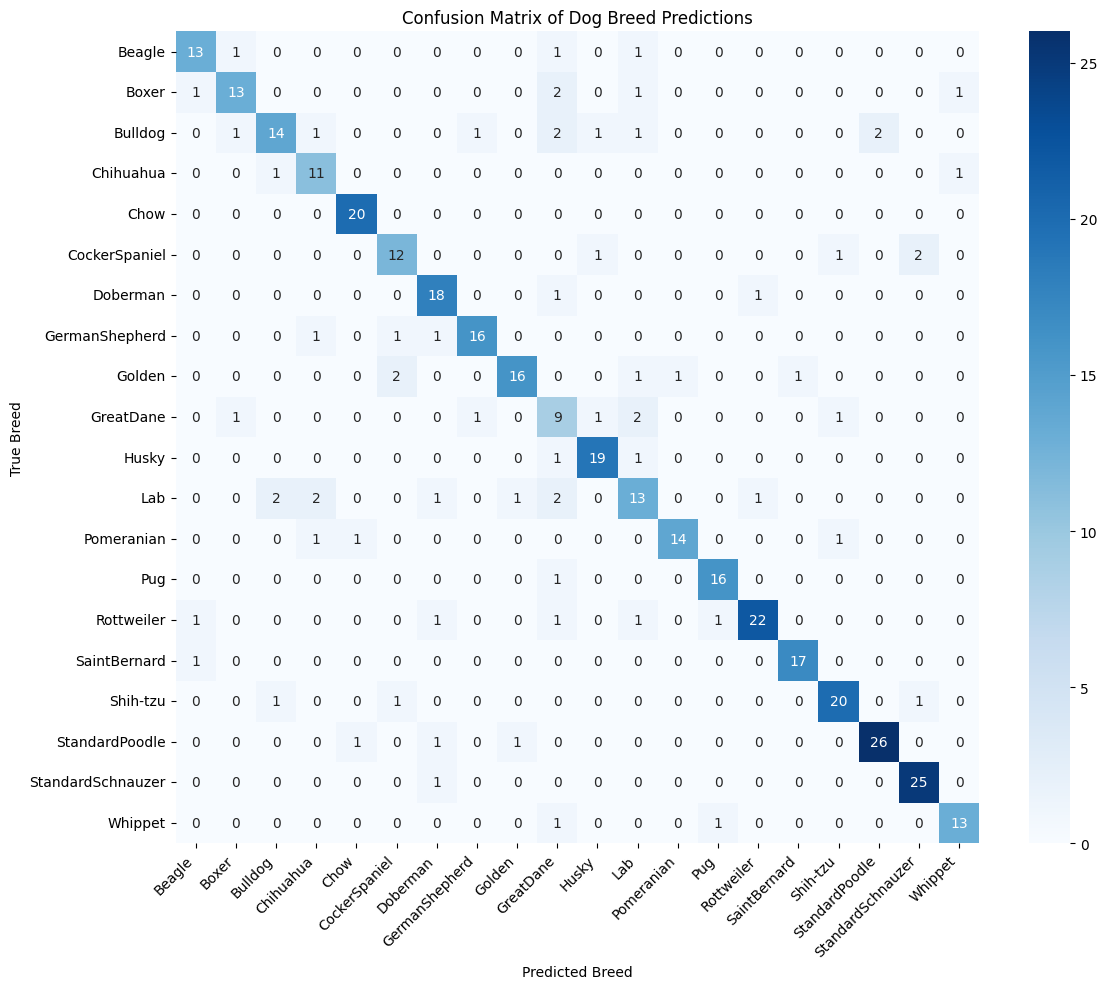

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(val_df['label'], val_df['predicted_breed'], labels=list(breed_to_index.keys()))

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=breed_to_index.keys(), yticklabels=breed_to_index.keys())
plt.xlabel("Predicted Breed")
plt.ylabel("True Breed")
plt.title("Confusion Matrix of Dog Breed Predictions")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()